In [12]:
from qiskit import QuantumCircuit
from qiskit_aer import AerProvider
from qiskit.circuit import Clbit, ClassicalRegister
from qiskit_experiments.library import StateTomography
from qiskit.visualization import array_to_latex, plot_state_city
from qiskit.quantum_info import DensityMatrix, Pauli
from itertools import repeat, product
from operator import add, mul
import numpy as np
from qiskit.primitives import Sampler
from qiskit_ibm_runtime import QiskitRuntimeService

In [3]:
st = StateTomography(qc)
backend = Aer.get_backend('aer_simulator')
stdata = st.run(backend, shots=1000).block_for_results()
state_result = stdata.analysis_results("state")
# array_to_latex(state_result.value)
plot_state_city(state_result.value)


NameError: name 'qc' is not defined

# Stoke's parameters tomography


In [28]:
def n_tomography(qc: QuantumCircuit, meas_qbits: list[int]) -> DensityMatrix:
    basis = [1, 2, 3]
    n_qbits = len(meas_qbits)
    p = np.zeros(list(repeat(6, n_qbits)))
    s = np.zeros(list(repeat(4, n_qbits)))
    s[0, 0] = 1
    for measurement in product(*repeat(basis, n_qbits)):
        print(f"Performing measurement {measurement}")
        sampler = Sampler()
        _qc = qc.copy()
        _qc.name = "".join("".join(str(i) for i in measurement))
        for i in range(0, n_qbits):
            m = measurement[i]
            if m == 1:
                _qc.h(meas_qbits[i])
            elif m == 2:
                _qc.sdg(meas_qbits[i])
                _qc.h(meas_qbits[i])
        
        cl_reg = ClassicalRegister(bits=[Clbit() for _ in range(n_qbits)])
        _qc.add_register(cl_reg)
        _qc.measure(meas_qbits, list(range(0, n_qbits)))   

        job = sampler.run(_qc)
        result = job.result()

        # print(f"Result: {result.quasi_dists[0]}")

        i = 0
        start = (np.array(measurement) - 1) * 2
        for delta in product(*repeat([0, 1], n_qbits)):
            res_obj = result.quasi_dists[0]
            prob = res_obj[i] if i in res_obj else 0
            pos = start + np.array(delta)
            p[*pos] = prob

            if sum(pos) % 2 == 0:
                s[*measurement] += prob
            else:
                s[*measurement] -= prob

            i += 1
    # print(p)
    for i in basis:
        j = 0
        start = (np.array([i, i]) - 1) * 2
        for delta in product(*repeat([0, 1], n_qbits)):
            pos = start + np.array(delta)
            if j % 2 == 0:
                s[0, i] += p[*pos]
            else:
                s[0, i] -= p[*pos]

            if j < (2 ** n_qbits) / 2:
                s[i, 0] += p[*pos]
            else:
                s[i, 0] -= p[*pos]

            j += 1
    # print(p)
    # print(s)

    p_map = ["I", "X", "Y", "Z"]
    density = np.zeros((2**n_qbits, 2**n_qbits), dtype=np.complex128)
    for measurement in product(*repeat([0] + basis, n_qbits)): 
        key = "".join([p_map[i] for i in measurement])
        pauli = Pauli(key).to_matrix()
        density += s[*measurement] * pauli
    density /= (2 ** n_qbits)

    return DensityMatrix(density)

qc = QuantumCircuit(2)
qc.h(0)
qc.h(1)

array_to_latex(n_tomography(qc, [0, 1]).data)


Performing measurement (1, 1)
Performing measurement (1, 2)
Performing measurement (1, 3)
Performing measurement (2, 1)
Performing measurement (2, 2)
Performing measurement (2, 3)
Performing measurement (3, 1)
Performing measurement (3, 2)
Performing measurement (3, 3)


<IPython.core.display.Latex object>

In [7]:
array_to_latex(DensityMatrix(qc).data)

<IPython.core.display.Latex object>

In [123]:
from common.qiskit_run import load_job_data

load_job_data("./quantum/data/amplitude_damping.json")

In [247]:
from common.qiskit_run import create_density_matrix, resolve_stokes
from qiskit.visualization import array_to_latex, plot_state_city
from qiskit.quantum_info import concurrence
from json import load

with open("./quantum/data/amplitude_damping.json") as f:
	exp = load(f)

sk = resolve_stokes(exp[0]["jobs"])
dm = create_density_matrix(sk)
array_to_latex(dm)

<IPython.core.display.Latex object>

# Maximum likelihood

In [4]:
import numpy as np
from math import sqrt, log, isnan
from itertools import product, repeat
from qiskit.quantum_info import Pauli
from scipy.optimize import minimize
from sympy import Matrix, Float, re, im

In [14]:
def T(t) -> np.matrix:
	size = sqrt(t.size)
	if not size.is_integer():
		raise Error("Size of t is not correct")
	
	size = int(size)
	_t = np.zeros((size, size), dtype=np.complex64)
	_t = np.matrix(_t)
	for i in range(0, size):
		_t[i, i] = t[i]
	
	p = size
	for d in range(1, size):
		for i in range(0, size - d):
			# p = (size * d) + (i * 2)
			_t[i + d, i] = complex(t[p], t[p + 1])
			p += 2

	return _t

def _c(v):
	return complex(*v.as_real_imag())

def initial_ts(dm):
	d = np.linalg.det(dm)
	sdm = Matrix(dm.tolist())

	m11 = _c(sdm.minor(0, 0))
	m12 = _c(sdm.minor(0, 1))
	m1122 = _c(sdm.minor_submatrix(0, 0).minor(0, 0))
	m1123 = _c(sdm.minor_submatrix(0, 0).minor(0, 1))
	m1223 = _c(sdm.minor_submatrix(0, 1).minor(0, 1))

	t5t6 = m12 / np.sqrt(m11 * m1122)
	t7t8 = m1123 / np.sqrt(dm[3, 3] * m1122)
	t9t10 = dm[3, 2] / np.sqrt(dm[3, 3])
	t11t12 = m1223 / np.sqrt(dm[3, 3] * m1122)
	t13t14 = dm[3, 1] / np.sqrt(dm[3, 3])
	t15t16 = dm[3, 0] / np.sqrt(dm[3, 3])
	return np.array([
		np.sqrt(d / m11),
		np.sqrt(m11 / m1122),
		np.sqrt(m1122 / dm[3, 3]),
		np.sqrt(dm[3, 3]),
		z
		t7t8.real,
		t7t8.imag,
		t9t10.real,
		t9t10.imag,
		t11t12.real,
		t11t12.imag,
		t13t14.real,
		t13t14.imag,
		t15t16.real,
		t15t16.imag,
	])

def rho(t):
	p = T(t).H * T(t)
	tr = p.trace()
	return p / tr

def likelihood(t):
	n_qubits = log(t.size, 4)
	if not n_qubits.is_integer():
		raise Error("Wrong size of t")
	n_qubits = int(n_qubits)

	s = 0
	basis = [0, 1, 2, 3]
	p_map = ["I", "X", "Y", "Z"]
	for mt in product(*repeat(basis, n_qubits)): 
		key = "".join([p_map[i] for i in mt])
		pauli = Pauli(key).to_matrix()

		exp = (rho(t) * pauli).trace()[0, 0]
		s += (exp - sk[*mt])**2 / (2 * exp)
	
	return s

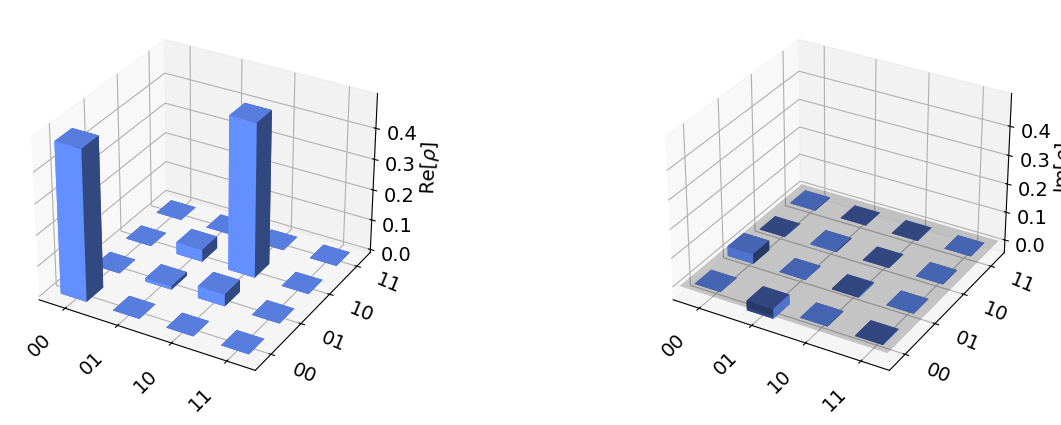

In [167]:
ini_ts = np.array([
	0.8585,
	0.0000,
	0.1450,
	0.0651,
	0.8108,
	-0.7840,
	0.1006,
	-0.0175,
	-0.0483,
	-0.2085,
	0.0750,
	0.0410,
	0.1515,
	-0.0431,
	-0.1572,
	0.4977,
])
res = minimize(likelihood, ini_ts, method="Powell")
res.x
plot_state_city(rho(res.x))

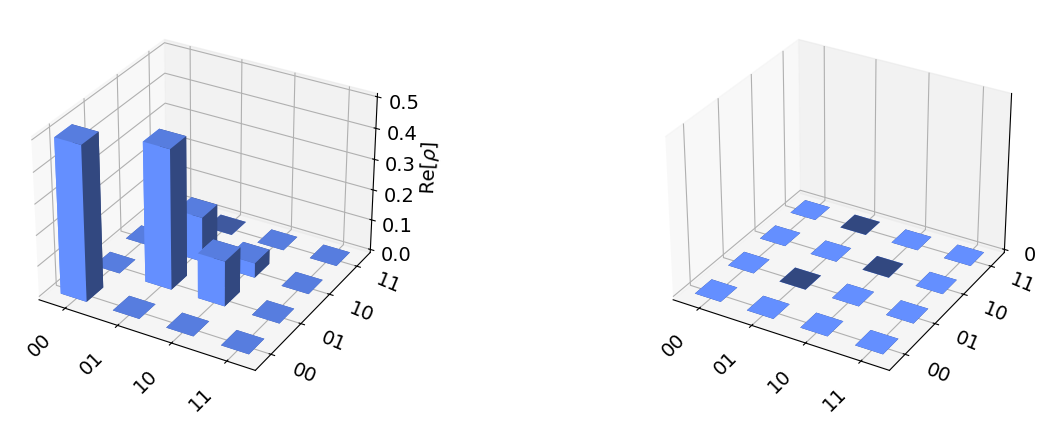

In [174]:
plot_state_city(theory_dm(0.5, pi/5))

In [25]:
np.linalg.cholesky(tdm)

LinAlgError: Matrix is not positive definite

In [13]:
from math import cos, sin, sqrt, pi
from itertools import product


def theory_dm(p, t):
    th = t / 2
    return np.matrix(
        [
            [p, 0, 0, 0],
            [0, (1 - p) * cos(th) ** 2, (1 - p) * cos(th) * sin(th), 0],
            [0, (1 - p) * cos(th) * sin(th), (1 - p) * sin(th) ** 2, 0],
            [0, 0, 0, 0],
        ]
    )


h = np.matrix([1, 0]).T
v = np.matrix([0, 1]).T
bs = {
    "h": h,
    "v": v,
    "d": (h + v) / sqrt(2),
    "a": (h - v) / sqrt(2),
    "r": (h + (1j) * v) / sqrt(2),
    "l": (h - (1j) * v) / sqrt(2),
}


def res_prob(dm: np.array) -> np.array:
    com = (("d", "a"), ("r", "l"), ("h", "v"))

    res = {}
    for k0, v0 in bs.items():
        for k1, v1 in bs.items():
            res[k0 + k1] = (np.kron(v0, v1).H * dm * np.kron(v0, v1)).item()

    return [
        [res[p10 + p11].real for (p10, p11) in product(p00, p01)]
        for (p00, p01) in product(com, com)
    ]

def res_stokes(dm: np.array) -> np.array:
    stokes = np.zeros((4, 4), dtype=np.complex128)
    p_map = ["I", "X", "Y", "Z"]
    for i in [0, 1, 2, 3]:
        for j in [0, 1, 2, 3]:
            pauli = Pauli("".join([p_map[i] for i in [i, j]])).to_matrix()
            stokes[i, j] = (dm * pauli).trace().item()

    return stokes


def res_jobs(probs):
    res = []
    for i in range(1, 4):
        for j in range(1, 4):
            p = probs[(i - 1) * 3 + j - 1]
            res.append(
                {
                    "s": [i, j],
                    "id": "test",
                    "result": {"0": p[0], "1": p[2], "2": p[1], "3": p[3]},
                }
            )
    return res

# array_to_latex(theory_dm(0.5, 0.62))
dm = theory_dm(0.5, pi / 25)
jobs = res_jobs(res_prob(dm))
sk = resolve_stokes(jobs)
exp_dm = create_density_matrix(sk)
array_to_latex(sk)

<IPython.core.display.Latex object>

## Kwait library

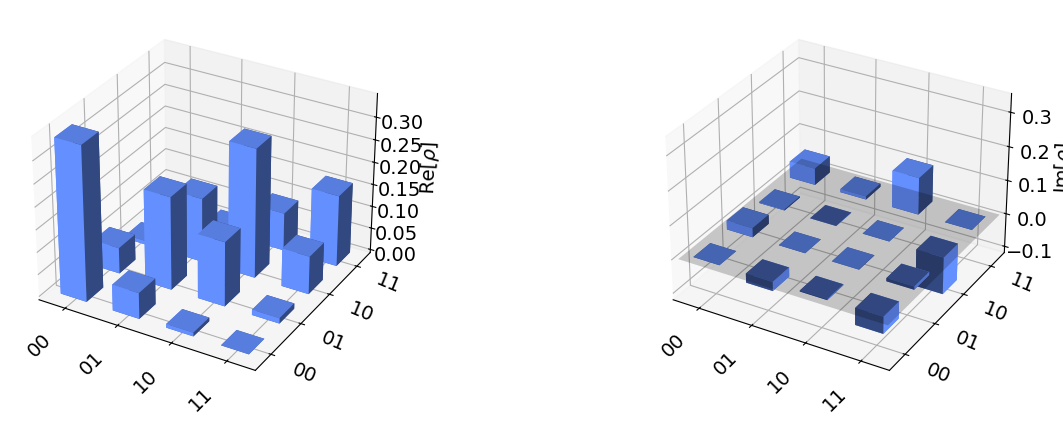

In [94]:
from QuantumTomography import Tomography

t = Tomography()

N = 10**5

def get_name(row):
	r = ""
	for (k, v) in bs.items():
		if np.linalg.norm(row[4:4+2] - v.T) < 0.01:
			r += k

	for (k, v) in bs.items():
		if np.linalg.norm(row[6:6+2] - v.T) < 0.01:
			r += k
	
	return r

tomo_input = t.getTomoInputTemplate()

# H
tomo_input[0][3] = exp[0]["jobs"][8]["result"]["0"] * N
tomo_input[1][3] = exp[0]["jobs"][8]["result"]["1"] * N
tomo_input[2][3] = exp[0]["jobs"][6]["result"]["0"] * N
tomo_input[3][3] = exp[0]["jobs"][6]["result"]["1"] * N
tomo_input[4][3] = exp[0]["jobs"][7]["result"]["0"] * N
tomo_input[5][3] = exp[0]["jobs"][7]["result"]["1"] * N
# V
tomo_input[6][3] = exp[0]["jobs"][8]["result"]["2"] * N
tomo_input[7][3] = exp[0]["jobs"][8]["result"]["3"] * N
tomo_input[8][3] = exp[0]["jobs"][6]["result"]["2"] * N
tomo_input[9][3] = exp[0]["jobs"][6]["result"]["3"] * N
tomo_input[10][3] = exp[0]["jobs"][7]["result"]["2"] * N
tomo_input[11][3] = exp[0]["jobs"][7]["result"]["3"] * N
# D
tomo_input[12][3] = exp[0]["jobs"][2]["result"]["0"] * N
tomo_input[13][3] = exp[0]["jobs"][2]["result"]["1"] * N
tomo_input[14][3] = exp[0]["jobs"][0]["result"]["0"] * N
tomo_input[15][3] = exp[0]["jobs"][0]["result"]["1"] * N
tomo_input[16][3] = exp[0]["jobs"][1]["result"]["0"] * N
tomo_input[17][3] = exp[0]["jobs"][1]["result"]["1"] * N
# A
tomo_input[18][3] = exp[0]["jobs"][2]["result"]["2"] * N
tomo_input[19][3] = exp[0]["jobs"][2]["result"]["3"] * N
tomo_input[20][3] = exp[0]["jobs"][0]["result"]["2"] * N
tomo_input[21][3] = exp[0]["jobs"][0]["result"]["3"] * N
tomo_input[22][3] = exp[0]["jobs"][1]["result"]["2"] * N
tomo_input[23][3] = exp[0]["jobs"][1]["result"]["3"] * N
# R
tomo_input[24][3] = exp[0]["jobs"][5]["result"]["0"] * N
tomo_input[25][3] = exp[0]["jobs"][5]["result"]["1"] * N
tomo_input[26][3] = exp[0]["jobs"][3]["result"]["0"] * N
tomo_input[27][3] = exp[0]["jobs"][3]["result"]["1"] * N
tomo_input[28][3] = exp[0]["jobs"][4]["result"]["0"] * N
tomo_input[29][3] = exp[0]["jobs"][4]["result"]["1"] * N
# L
tomo_input[30][3] = exp[0]["jobs"][5]["result"]["2"] * N
tomo_input[31][3] = exp[0]["jobs"][5]["result"]["3"] * N
tomo_input[32][3] = exp[0]["jobs"][3]["result"]["2"] * N
tomo_input[33][3] = exp[0]["jobs"][3]["result"]["3"] * N
tomo_input[34][3] = exp[0]["jobs"][4]["result"]["2"] * N
tomo_input[35][3] = exp[0]["jobs"][4]["result"]["3"] * N

(rhog,*_) = t.StateTomography_Matrix(tomo_input, method="MLE")

plot_state_city(rhog)

In [279]:
np.sqrt(dm.data.shape[0])

2.0

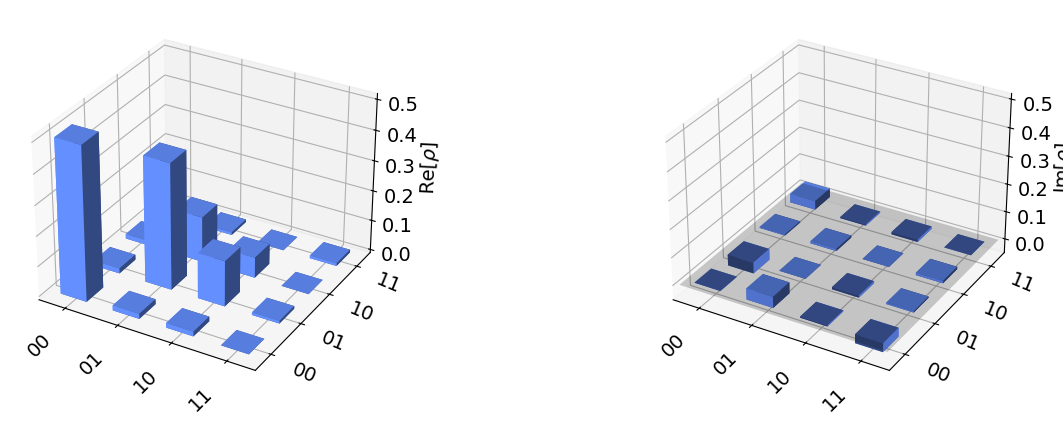

In [284]:
def dm_optimize(mu):
	d = mu.shape[0]
	(mu_val, mu_vec) = np.linalg.eig(mu.data)

	arg = np.flip(np.argsort(mu_val))
	mu_vec = np.transpose(mu_vec)[arg]
	mu_val = mu_val[arg]

	lam = np.zeros(d, dtype=np.complex128)
	i = d - 1
	a = 0
	while mu_val[i] + a / (i+1) <= 0 :
		lam[i] = 0
		a += mu_val[i]
		i -= 1

	for j in range(0, i + 1):
		lam[j] = mu_val[j] + a / (i+1)

	rho = np.zeros((d, d), dtype=np.complex128)
	for i in range(0, d):
		rho += lam[i] * np.outer(mu_vec[i], mu_vec[i].conj())
	
	return rho

plot_state_city(dm_optimize(dm.data))
